# Sentiment analysis project : Should we do away with star ratings?

The goal of this modeling task is to compare the effectiveness of lexicon-based sentiment analysis (i.e., text blob) to transfer learning with pre-trained models in predicting the sentiment of yelp reviews. Are these methods good enough to replace the yelp star ratings?  The dataset used for this project consists of over 600,000 yelp reviews. A random sample of 100,000 reviews will be used to compare the sentiment approximation of text-blob to transfer learning. 

## Part 1: Setup and preprocessing

In [117]:
# import dependencies 
from textblob import TextBlob# load textblob
from transformers import pipeline
from plotnine import *
import pandas as pd
import numpy as np

In [118]:
#import data
reviews_df = pd.read_sql_table("review", "sqlite:///yelpHotelData.db")
reviews_df.shape

(688329, 10)

In [119]:
reviews_df.sample(5)

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID
468868,6/25/2012,03Vz2iat9i82xmYys2GAFg,EQqor5tO_1L8lseEhpDYPA,SOOOO much fun!!! My first ever visit to Kit K...,4,0,0,0,NR,IITu5GokSXIJC902vV_b0A
97953,10/3/2011,cATUpiWfKnD8Jitur4LyUw,pDfL8xt8F8ls0-kQIG_ADg,Saw these guys at OTG - Golden Gate Fields. (h...,3,9,9,8,NR,gMzmDrolKaqXW-ayQv-bfA
667968,11/24/2009,9AvvKyngajMHdsHva60DGg,Xj0O2l0bp633ebmG468aZw,"A funny little karaoke bar, with lots of early...",3,0,0,0,YR,sinxb1F7g1GEm01XSB3qCw
295044,4/12/2009,iJ-Hij8aFdMQMyyOOQRFVQ,fcNU65OaCj7slBJ60VSQgw,I came here to get my coupon book for adopting...,3,1,1,0,NR,EzpJKBxwFy4ikASZvMmlhA
213063,2/18/2007,3N5TQ83IWA_0_ySkopJBUw,P5bUL3Engv-2z6kKohB6qQ,One of those funky parking garages where you n...,4,2,1,1,NR,So-qLfvO-Q2OSfMu_HzaoA


In [120]:
#check for missingness
reviews_df.isna().sum()

date             0
reviewID         0
reviewerID       0
reviewContent    0
rating           0
usefulCount      0
coolCount        0
funnyCount       0
flagged          0
hotelID          0
dtype: int64

In [121]:
# distribution of star ratings 
reviews_df.rating.value_counts()

4    267027
5    171715
3    154637
2     62560
1     32390
Name: rating, dtype: int64

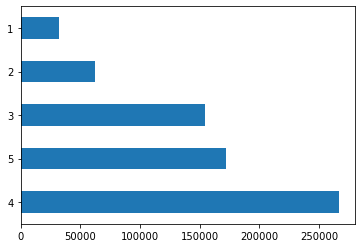

In [122]:
reviews_df.rating.value_counts().plot.barh()

Most reviews in this dataset have a positive rating (i.e,  4 and 5 star ratings). Since the data set is massive, let's take a random sample of 100,000 observations to make computation easier. Note that this will result in a loss of some information, but for our purpose of comparing the effectiveness of two sentiment analysis methods and not making any causal inferences, a random sample should suffice. 


In [123]:
#take a random sample of 100,000 observations
small_df=reviews_df.sample(100000, random_state=17)
small_df.head(5)

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID
529630,7/18/2012,IcQdGFX8cr5CrH_uiVsY1Q,lUAEesLvvNUAYqqkxLFpgQ,Very huge assortment of unique burgers that we...,4,0,0,0,NR,oCTlReyKjJxKPFYfCurxxQ
501344,7/4/2009,5Iy4e8qOh7WVoLtJ_sC21g,53tt0Msa4UqwtU_-JppHQQ,I'd never heard of a Corner Bakery until a rec...,3,0,0,0,NR,XA-Mch8SREJ_AQWlrYyzbw
62307,6/25/2008,tq5uYbYZfixh-OhWecufZg,WPRuJp0BhNdlgYXKZewpDg,This isn't bad ice cream - it's not like you'l...,2,0,0,0,YR,7Y2Yr5SbJfQ2oeKrpTeQBA
440225,2/2/2012,TRQU_S6Ik0SGs0URRab9QA,kY_GzlFxLkXK_2ln4l-l-A,This place is just good mexican food. I eat h...,3,0,0,0,NR,JcQeF1bYTas28ewN0QotBQ
125323,7/13/2008,GG5hQ2_C_FjXO_IIPdsJmA,5QrgnLkqhduFMKfm66Aqog,Here's the deal people. I was really nervous t...,4,3,3,1,NR,_4hwlnlFzm7YDP1D81ecKw


The column that is of most interest is the 'reviewContent' column. As shown in the code chunk below, the length of some of the responses provided by reviewers is quite long:

In [124]:
length=[]
for i in small_df.reviewContent:
    length.append(len(i))

In [125]:
max(length)

4994

In [126]:
for i in small_df.reviewContent:
    if len(i)==4994:
        print(i)

Location: 4 out of 5 Bad news: it's on the Parkway in Pigeon Forge.  Good news: It's at the very end of the Parkway in Pigeon Forge.  That way, you can get a head start into the mountains.  To get to the main "attractions" and dining options, you'll have to take the trolley or use your car/motorcycle.  I'd recommend the trolley - it's quick and cheap, and has fairly regular service.   Cleanliness of Room: 2.5 out of 5 Ok, let's get the ugly out of the way first.  Nothing was in terrible or disgusting shape, but there were some visible signs of wear and tear that I think need to be addressed.  I stayed in 1114, and the predominant things I noticed were: the mesh screen that serves as a 'filter' for the AC/heat unit was riddled with lint and small gravel(?).  I don't have breathing problems, but I could imagine that if someone were more sensitive to dust, this could cause a problem.  The linoleum in the bathroom was in poor shape around the edges, as were the edges of the wallpaper in th

As you can see above, one reviewer provided a text response that has a length of 4994. Having multiple reviews that are as long as this makes it difficult for the pre-trained model method we are using to generate sentiment labels. This method wouldn't be able to generate a sentiment approximation for our entire sample of responses because it has a hard limit on the number of tokens allowed. See additional information about this here: https://medium.com/dair-ai/longformer-what-bert-should-have-been-78f4cd595be9 .

To make things easier, we will further alter our dataframe to only include text responses that have a length that is less than 150. Again, filtering reponses does reduce the amount of information we can glean. However, since our goal is to simply compare performance with regards to star rating classification, this methodology will suffice.

In [127]:
# remove reviews longer than 150 words 
small_df['length'] = small_df.reviewContent.str.len()
small_df=small_df[small_df['length']<150]
small_df.head()

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID,length
600935,2/5/2009,xLkWo-zszIfn77fjxDvOJA,gOPm2yoe38_OM6x4NIwLEw,Rich and delicious.,5,0,0,0,YR,OiP8yvkLXaygzWx8eQOimw,19
412071,Update - 8/27/2010,1O-_ynafQjzS2oX5cAkG0Q,TEHiUF-e8pa37rByg15MmA,Yay! They expanded!,4,1,0,0,YR,nnImffGgWMtHb0R1affLEA,20
552252,Update - 12/29/2008,LBLER995DvIJBz2ZoUc6Eg,Un9kXZRrhnfdhaW33OwLFg,HA! Closed - what did I tell you!,1,3,3,3,NR,MBYC7FzDkhTUnlwNX2Lj2Q,34
686275,8/20/2010,dqgxopruLGNkzOdTCQL_mQ,OMnge3tUQLvrnkW1uZNu5Q,awesome. croque madame is fantastic.,5,0,1,0,YR,afSsDoER6eHgBoiB8a0kUA,36
512523,11/2/2005,vv7nEANB1nAD5FKhwNXIMQ,Da_ZO8lKwIacljqKUJbAlw,best green iced tea ever!,5,0,0,0,YR,bI0djBt4exAWQQOxaVexDA,25


Let's explore the dataset :

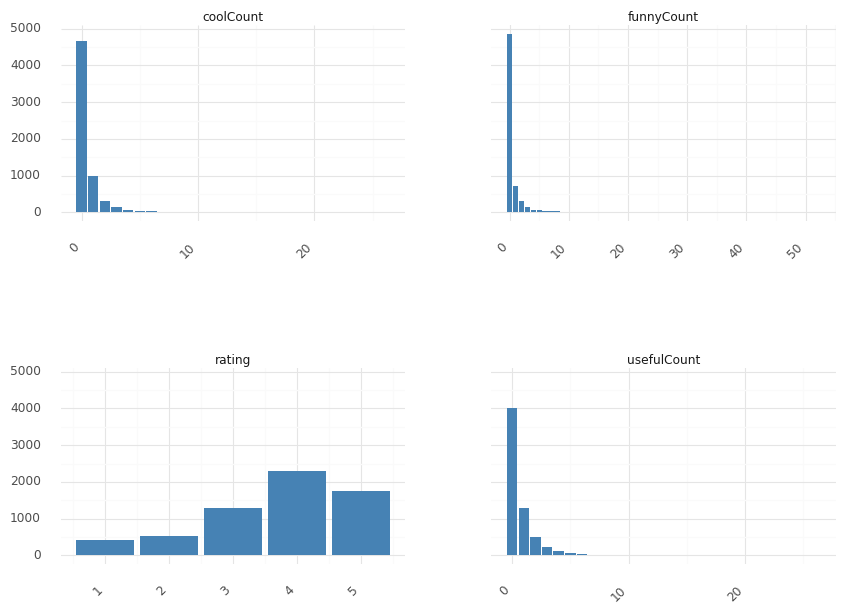

<ggplot: (8785990946545)>

In [128]:
small_df_dist=small_df.filter(['rating', 'usefulCount', 'coolCount', 'funnyCount']).melt()
(ggplot(small_df_dist, aes(x="value")) + facet_wrap("variable", scales="free_x") +
geom_bar(fill="steelblue")+ theme_minimal()+theme(figure_size=(10,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))+labs(x="", y=""))

Although it is interesting to see that most reviews are not considered cool, funny, or useful , our main interest is the rating column. As we saw earlier, our corpus mainly consists of positive and neutral reviews. There are comparatively fewer negative reviews. 

For our design, we will opt to remove neutral ratings (i.e., reviews with a rating of 3). This way we can simply compare the two sentiment analysis methods based on their determination of negative (start rating of 1 or 2) vs. positive reviews (star rating of 4 or 5). 

In [129]:
#remove reviews with a rating of 3
small_df = small_df[small_df["rating"] != 3].reset_index()

In [130]:
small_df.shape

(4995, 12)

In [131]:
small_df['rating'].value_counts()

4    2302
5    1753
2     518
1     422
Name: rating, dtype: int64

## Methodology and Results

### `Lexicon-based sentiment analysis with TextBlob`

The first tool we will be using is TextBlob, a lexicon-based sentiment analysis tool. TextBlob uses rule-based decisions by using manually created dictionaries. Because we are using this method for sentiment analysis, each document in our corpus will be assigned a polarity and a subjectivity score. For our purpose, we will rely on the polarity score which has a range from -1 to 1, with -1 being negative and 1 being positive. We will start by looping through each document/review and supply the reviewContent column to the textblob model one at a time. This column contains actual text reviews. Our goal is to see how results from textblob compare to the numeric ratings provided by customers themselves. 

In [132]:
#list comprehension to loop through each text review and store results to a list object
text_blob_results=[TextBlob(i).sentiment for i in small_df['reviewContent']]

In [133]:
#convert list object to dataframe for easier viewing and data manipulation
text_blob_results=pd.DataFrame(text_blob_results)

In [134]:
#join text blob to sampled dataframe using the index; compare rating to polarity results from text blob.
text_blob_results=text_blob_results.join(small_df)

In [135]:
text_blob_results=text_blob_results.filter(['reviewContent', 'rating', 'polarity'])
text_blob_results.head(5)

,reviewContent,rating,polarity
0,Rich and delicious.,5,0.6875
1,Yay! They expanded!,4,0.0000
2,HA! Closed - what did I tell you!,1,-0.1250
3,awesome. croque madame is fantastic.,5,0.7000
4,best green iced tea ever!,5,0.3750


/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 34'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


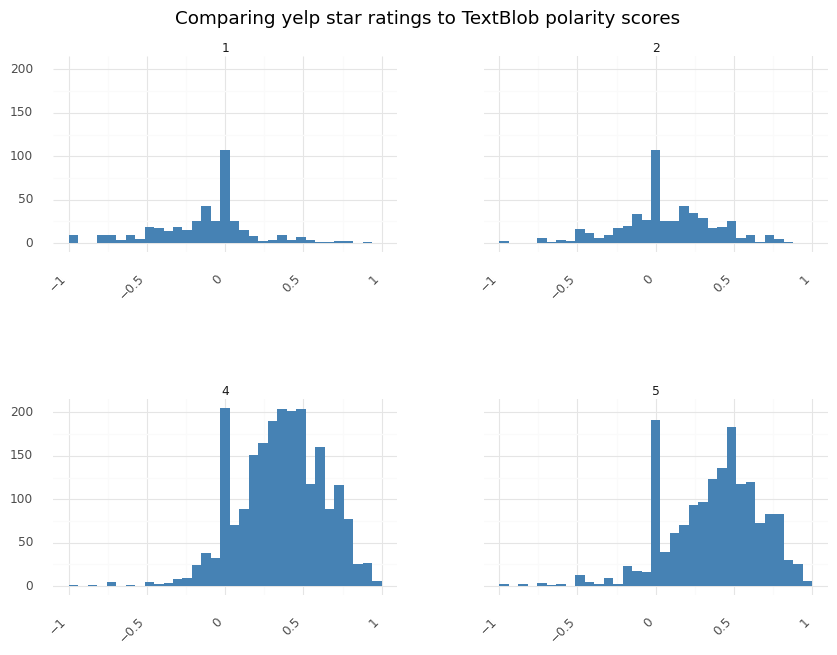

<ggplot: (8786014075645)>

In [136]:
(ggplot(text_blob_results, aes(x="polarity")) + facet_wrap("rating", scales="free_x") +
geom_histogram(fill="steelblue")+ theme_minimal()+ theme(figure_size=(10,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))+labs(x="", y=""))+ labs(title="Comparing yelp star ratings to TextBlob polarity scores")

Looking at the plots above we can see that reviews with a star rating of 1 have polarity scores that are mostly negative (i.e, below 0). However, there are reviews that were actually given a positive polairty score despite haviing a star rating of 1. Also, there is a peak at about 0, indicating that about 100 responses with a star rating of 1 were determined to be 'neutral' reviews by TextBlob. Converesley, we see that there are far more 2-star rating reviews that were determined to be 'positive' based on TextBlobs assessment. Similar to 1-star rating reviews, there is peak at 0 indicating that TextBlob continues to think that certain 2-star reviews are actually netural. 

Moving on the 4 and 5 star reviews, we see that there is a pronounced skew, where a signficant number of reviews are catagorized as positive reviews by TextBlob. Although there are still reviews that were deemed to be negative by TextBlob, despite having positive star ratings. Interestingly, the peak at 0 polarity is evident in 4 and 5 star reviews as well. Let's take a closer look at these supposedly 'netural' reviews. 

In [137]:
text_blob_results[text_blob_results['polarity']==0]

,reviewContent,rating,polarity
1,Yay! They expanded!,4,0.0
6,Hmm...,1,0.0
15,I like the different options that you have at ...,4,0.0
16,"...sucks when you're housebound, studying for ...",2,0.0
54,I got take out pho from here once and had no c...,4,0.0
...,...,...,...
4966,I do not want to get audited so my stars are m...,1,0.0
4973,Like your song....... Gone too soon.......,5,0.0
4979,I've been to this bar! Wasn't it on Lincoln A...,2,0.0
4984,the food is GROSS!!!,1,0.0


Looking at the sample of results above, we can clearly see that TextBlob has made some mistakes. For instance, the first review seems to be a very positive response and has a 4-star rating. However, TextBlob has given it a neutral polarity, thinking that this response is neither negative nor positive. If we did not have the star rating and simply relied on TextBlob, we would not be getting the right picture on how customers/reviewers feel about this specific establishment. Another interesting mistake is the polarity score assigned to the second to last review. The reviewer is clearly describing a negative feeling by stating that the food at an establishment is not pleasing. However, based on the manual dictionary it is based on, TextBlob determined that this review is neutral. If we did not have the star-rating and only relied on sentiment analysis via TextBlob, we would not be providing the most reliable representation of the reviewer's sentiment about the establishment. 

______

## `Transfer learning with pre-trained models`

Our second method will be using pre-trained models to determine the sentiment of yelp review by only looking at text responses, then comparing the outcome to the actual star rating provided by reviewers. Unlike TextBlob, transfer learning with pre-trained models does not rely on the strict approach of rule-based decision making. Instead, we will be using a pre-trained model that have accumulated knowledge by being trained on large amounts of data from the internet. These models will be able to glean knowledge by being exposed to the structure of the various sources of text from the interent. We will be using hugging face transformers, which is an API with a library of pre-trained models. Furthermore, unlike TextBlob, the pretrained model will label reviews as either negative or positive. There is no range as in TextBlob polarity scores.

In [138]:
#instantiate pipeline model object
cls = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [139]:
#loop through each review and supply it to the text-classification pipeline instantiated above
transformers_results=[cls(i) for i in small_df['reviewContent']]

In [140]:
#quick preview of results 
transformers_results[0:5]

[[{'label': 'POSITIVE', 'score': 0.9998828172683716}],
 [{'label': 'POSITIVE', 'score': 0.9986914992332458}],
 [{'label': 'POSITIVE', 'score': 0.9227570295333862}],
 [{'label': 'POSITIVE', 'score': 0.9998838901519775}],
 [{'label': 'POSITIVE', 'score': 0.9998379945755005}]]

Let's view the results as a dataframe and join the resulting dataframe to to inital corpus with the star-ratings:

In [141]:
from itertools import chain

In [142]:
transformers_results=pd.DataFrame(list(chain.from_iterable(transformers_results)))
transformers_results

,label,score
0,POSITIVE,0.999883
1,POSITIVE,0.998691
2,POSITIVE,0.922757
3,POSITIVE,0.999884
4,POSITIVE,0.999838
...,...,...
4990,POSITIVE,0.999877
4991,POSITIVE,0.999856
4992,POSITIVE,0.999426
4993,NEGATIVE,0.999727


In [143]:
transformers_results=transformers_results.join(small_df).filter(['reviewContent', 'rating', 'label', 'score'])
transformers_results

,reviewContent,rating,label,score
0,Rich and delicious.,5,POSITIVE,0.999883
1,Yay! They expanded!,4,POSITIVE,0.998691
2,HA! Closed - what did I tell you!,1,POSITIVE,0.922757
3,awesome. croque madame is fantastic.,5,POSITIVE,0.999884
4,best green iced tea ever!,5,POSITIVE,0.999838
...,...,...,...,...
4990,A real family jewel of Chicago. Excellent food...,4,POSITIVE,0.999877
4991,"Great local Silverlake gastropub. Healthy, yet...",4,POSITIVE,0.999856
4992,This heb has everything!,5,POSITIVE,0.999426
4993,Dinner for two was over $100 and the portions ...,1,NEGATIVE,0.999727


/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


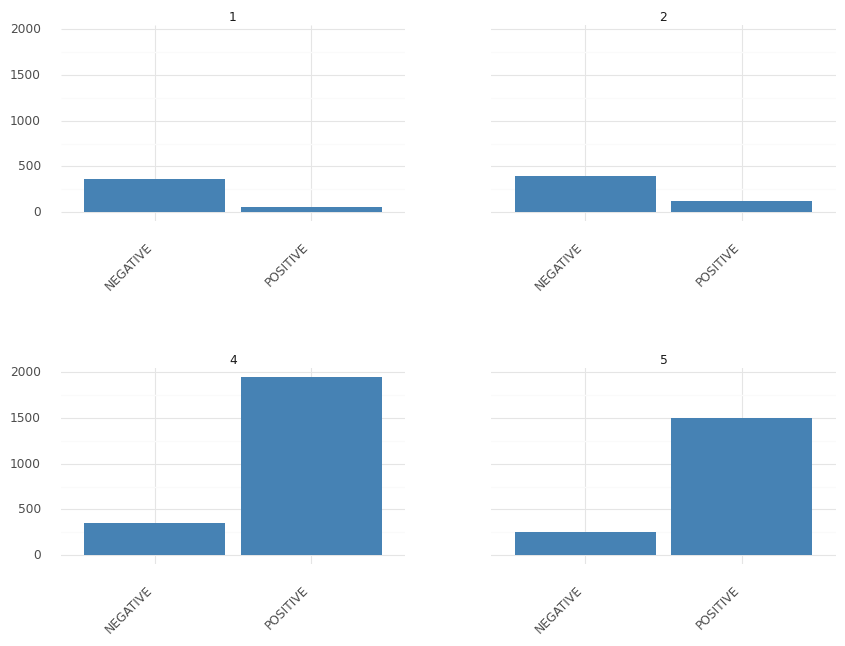

<ggplot: (8786088174445)>

In [144]:
(ggplot(transformers_results, aes(x="label")) + facet_wrap("rating", scales="free_x") +
geom_bar(fill="steelblue")+ theme_minimal()+theme(figure_size=(10,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))+labs(x="", y=""))

Looking at the results above, we see that the pre-trained model we use has roughly similar patterns as the rule-based method. 1 and 2 star-ratings are mostly classified as negative, but there are still some reviews that have been classified as positive. The reverse is true with 4 and 5 star-ratings, where most reviews are classified as positive while a few are classified as negative. Let us look closely at the results to see where the mistakes are happening. 

In [145]:
#extract 5-star ratings with a negative label
transformers_results[(transformers_results['rating']==5) & (transformers_results['label']=="NEGATIVE")]

,reviewContent,rating,label,score
18,Hand scoring? Excuse me? Does it GET ANY BETTE...,5,NEGATIVE,0.999652
30,Tons of xs clothes on dirt cheap sale! Go now!,5,NEGATIVE,0.995427
51,"I would give Best Wurst 5 stars sober, so it's...",5,NEGATIVE,0.899951
72,Sad to say after 50 years in business they hav...,5,NEGATIVE,0.820195
82,If you go anywhere else in Greektown you are a...,5,NEGATIVE,0.990756
...,...,...,...,...
4812,Yummy indeed! Best place to get flan in Seattl...,5,NEGATIVE,0.995792
4864,"if you want some healthy fast food, koo koo ro...",5,NEGATIVE,0.833421
4908,"Ah, even though there's only 1 Dunkin Donuts i...",5,NEGATIVE,0.996116
4918,Garrett Popcorn Shops [from the 2008 Wine and ...,5,NEGATIVE,0.976236


In [146]:
np.array(transformers_results[(transformers_results['rating']==5) & (transformers_results['label']=="NEGATIVE")])[0:5]

array([['Hand scoring? Excuse me? Does it GET ANY BETTER?!?!?! I think not.',
        5, 'NEGATIVE', 0.9996517896652222],
       ['Tons of xs clothes on dirt cheap sale! Go now!', 5, 'NEGATIVE',
        0.9954273700714111],
       ["I would give Best Wurst 5 stars sober, so it's like eleventy stars after a night out on 6th. \xa0Reason #385 I miss Austin.",
        5, 'NEGATIVE', 0.8999512791633606],
       ['Sad to say after 50 years in business they have closed there doors.... you guys will be missed, good luck in the future were ever it may take you all',
        5, 'NEGATIVE', 0.820194661617279],
       ['If you go anywhere else in Greektown you are a suckah. Trust me--I know. Except maybe Santoirini is better for seafood. Nuf said.',
        5, 'NEGATIVE', 0.990756094455719]], dtype=object)

We can see that the pre-trained model we used labeled the first review above (which is a very positive review) as being negative and it even assigned the label a high score. The same can be said for the other reviews previewed in the above code chunk.

To compare the models, let us look at how many mistakes they made in assessing the sentiment of extreme ratings (i.e. 1-star and 5-star ratings). 

In [147]:
#combine results from both models
combined_df=text_blob_results.join(transformers_results, how='left', lsuffix='_left', rsuffix='_right')
combined_df

,reviewContent_left,rating_left,polarity,reviewContent_right,rating_right,label,score
0,Rich and delicious.,5,0.687500,Rich and delicious.,5,POSITIVE,0.999883
1,Yay! They expanded!,4,0.000000,Yay! They expanded!,4,POSITIVE,0.998691
2,HA! Closed - what did I tell you!,1,-0.125000,HA! Closed - what did I tell you!,1,POSITIVE,0.922757
3,awesome. croque madame is fantastic.,5,0.700000,awesome. croque madame is fantastic.,5,POSITIVE,0.999884
4,best green iced tea ever!,5,0.375000,best green iced tea ever!,5,POSITIVE,0.999838
...,...,...,...,...,...,...,...
4990,A real family jewel of Chicago. Excellent food...,4,0.600000,A real family jewel of Chicago. Excellent food...,4,POSITIVE,0.999877
4991,"Great local Silverlake gastropub. Healthy, yet...",4,0.575000,"Great local Silverlake gastropub. Healthy, yet...",4,POSITIVE,0.999856
4992,This heb has everything!,5,0.000000,This heb has everything!,5,POSITIVE,0.999426
4993,Dinner for two was over $100 and the portions ...,1,-0.472917,Dinner for two was over $100 and the portions ...,1,NEGATIVE,0.999727


Below we will calculate the share of 1-star and 5-star ratings that were mislabeled by both methods:

`One-star review mislabeling by transfer learning method`

In [148]:
(combined_df[(combined_df['rating_left']== 1) & (combined_df['label']=='POSITIVE')].shape[0]/combined_df[(combined_df['rating_left']== 1)].shape[0])*100

13.744075829383887

`Five-star review mislabeling by transfer learning method`

In [149]:
(combined_df[(combined_df['rating_left']== 5) & (combined_df['label']=='NEGATIVE')].shape[0]/combined_df[(combined_df['rating_left']== 5)].shape[0])*100

14.147176269252709

`One-star review mislabeling by lexicon-based method`

In [150]:
(combined_df[(combined_df['rating_left']== 1) & (combined_df['polarity']>0)].shape[0]/combined_df[(combined_df['rating_left']== 1)].shape[0])*100

22.03791469194313

`Five-star review mislabeling by lexicon-based method`

In [151]:
(combined_df[(combined_df['rating_left']== 5) & (combined_df['polarity']<0)].shape[0]/combined_df[(combined_df['rating_left']== 5)].shape[0])*100

5.989731888191671

### Conclusion

Looking at the results above, we can see that the lexicon-based approach misclassified one-star reviews more often than the transfer learning with pre-trained model approach. Converesley, the transfer learning approach misclassified five-star reviews more often than the lexicon-based approach. 

In the context of our original question (i.e., can we replace star-rating by either lexicon-based and transfer learning with pre-trained model approaches?), our results show that replacing star-ratings by these methods is not advisable. Although these methods use different strategies to analyze sentiment, they both rely on methodologies that were creating based on the assumptions and decisions of a select number of decision makers. With regards to lexicon-based sentiment analysis, the researchers who design the dictionary are the ones that decide the weight assigned to words. Language is constantly changing, calling into question the effectiveness of such a strict methodology to fully capture the feeling of yelp reviewers. Additionally, the transfer learning approach uses pre-trained models that were trained with text that could be riddled with various unethical and improper training data. As it stands today, we have no certainity about the type of auditing measures emplyed on these data sources that are being use to pre-train models for sentiment analysis. Although these methods do offer some insights, we can not forget that they are desinged based on assumptions. As we saw above, some of the mistakes being made blatantly misclassify reviews at times with what the model sees as high certainity/scores. All in all, i do not think that these methods are good enough to replace star-ratings. Most importantly, the star-ratings allow users to quantify their own perspective, which i think is a far more valuable insight that relying on crude methods like lexicon-based decision making or methods withouts enough oversight like pre-trained models. If we wish to derive insight about users, the star-ratings should remain.